# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
#!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

In [2]:
# Installing the libraries with the specified version.
# uncomment and run the following lines if Jupyter Notebook is being used
#!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.11.1 matplotlib==3.3.4 numpy==1.24.3 pandas==1.5.2 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split                            # Importing train_test_split from sklearn

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from google.colab.patches import cv2_imshow                                          # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [4]:
# Uncomment and run the below code if you are using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the image file of dataset
images = np.load('/content/drive/MyDrive/Great Learning/Projects /Comp vision Plant Seedling Classifier/images.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/MyDrive/Great Learning/Projects /Comp vision Plant Seedling Classifier/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [6]:
print ("images file shape", images.shape)
print ("labels file size", labels.shape)

images file shape (4750, 128, 128, 3)
labels file size (4750, 1)


**Observation**:

1. The input data file contains images in npy file format. There are 4750 images that are 128*128 pixels size.
2. All images have 3 Channels representing RGB color channels, so all 4750 images are color images.  
3. Label files contain the image classifications.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

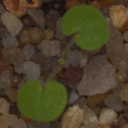

In [7]:
cv2_imshow(images[5])

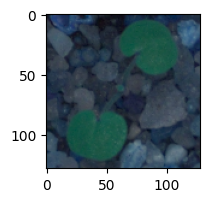

In [8]:
plt.figure(figsize=(2, 2))
plt.imshow(images[5])

Printing one image per category below.

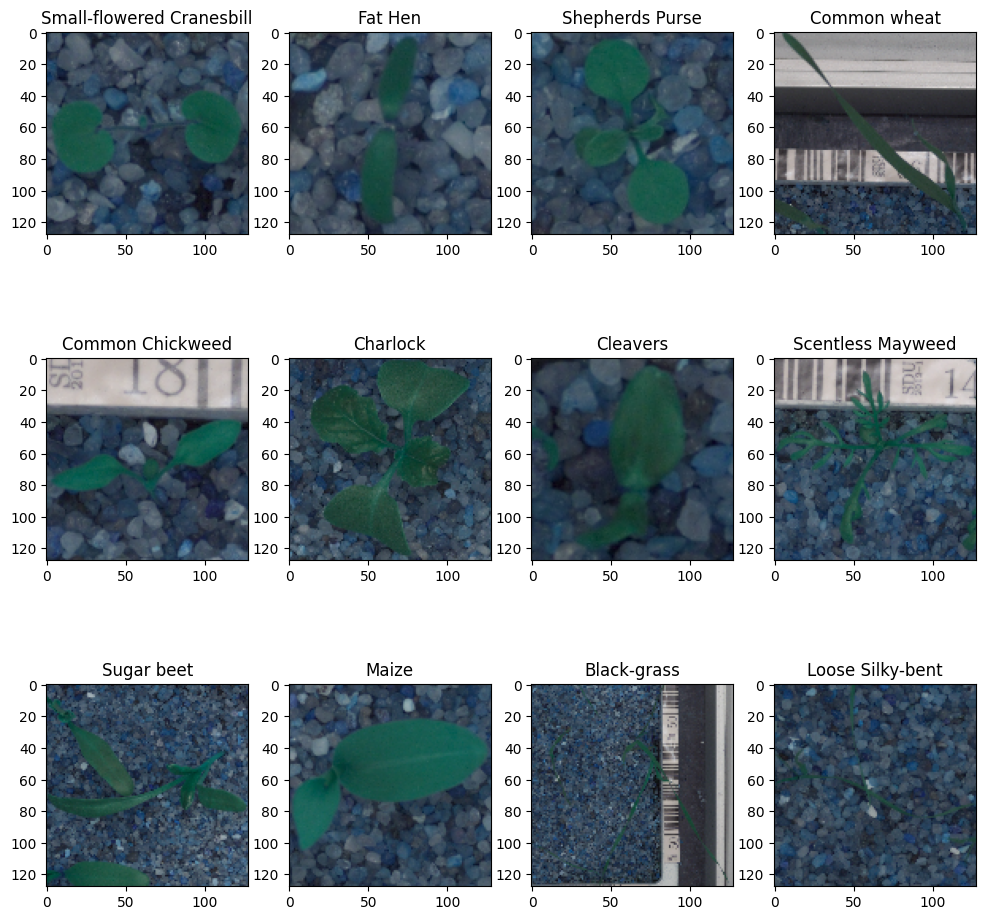

In [9]:
def plot_images(images,labels):
  fig = plt.figure(figsize=(12, 12))
  for i,label in enumerate(labels['Label'].unique()):
      index= np.where(labels['Label']==label)[0][0]
      ax = fig.add_subplot(3, 4, i+1)                      # Adding subplots with 3 rows and 4 columns
      ax.imshow(images[index, :])                                      # Plotting the image
      ax.set_title(label)
  plt.show()

plot_images(images,labels)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Loose Silky-bent'),
  Text(1, 0, 'Common Chickweed'),
  Text(2, 0, 'Scentless Mayweed'),
  Text(3, 0, 'Small-flowered Cranesbill'),
  Text(4, 0, 'Fat Hen'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Sugar beet'),
  Text(7, 0, 'Cleavers'),
  Text(8, 0, 'Black-grass'),
  Text(9, 0, 'Shepherds Purse'),
  Text(10, 0, 'Common wheat'),
  Text(11, 0, 'Maize')])

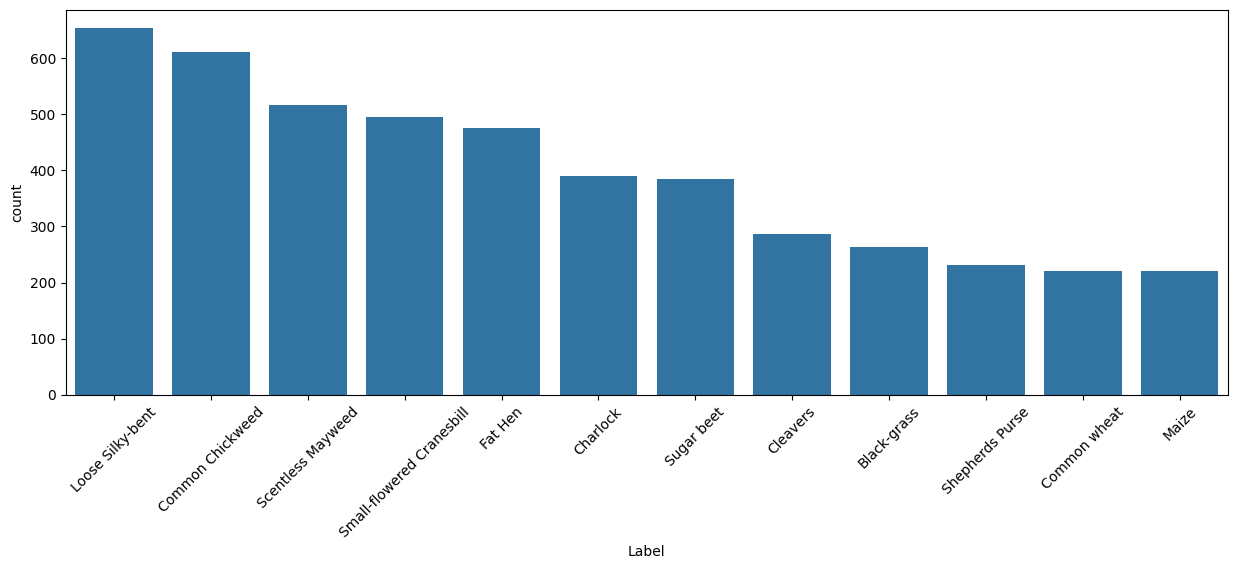

In [10]:
plt.figure(figsize=(15,5))
sns.countplot(labels, x=labels['Label'], order = labels['Label'].value_counts().index)
plt.xticks(rotation=45)

### **Observation:**

1.   npyc file stores the channels in BGR format but matplot expects the data  to be in RGB format, so when displayed using matplot the red color is presented as blue in the image grid above.
2.  There are 12 different types of seedlings images in the file and one image sample per seedling is displayed in the grid above using matplot.
3. Based on the count plot, it is observed that the data is imbalanced. The data contains very few sample images of Shepards Purse, Common Wheat, Cleavers, Mainze, Black-grass. This will require data augmentation to predict well.
4. Maximum number of images are available for Loosely Silkty-bent(more than 600 images) and minimum number of images for maize (approx 200 images).




## Data Pre-Processing

### Convert the BGR images to RGB images.

In [11]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

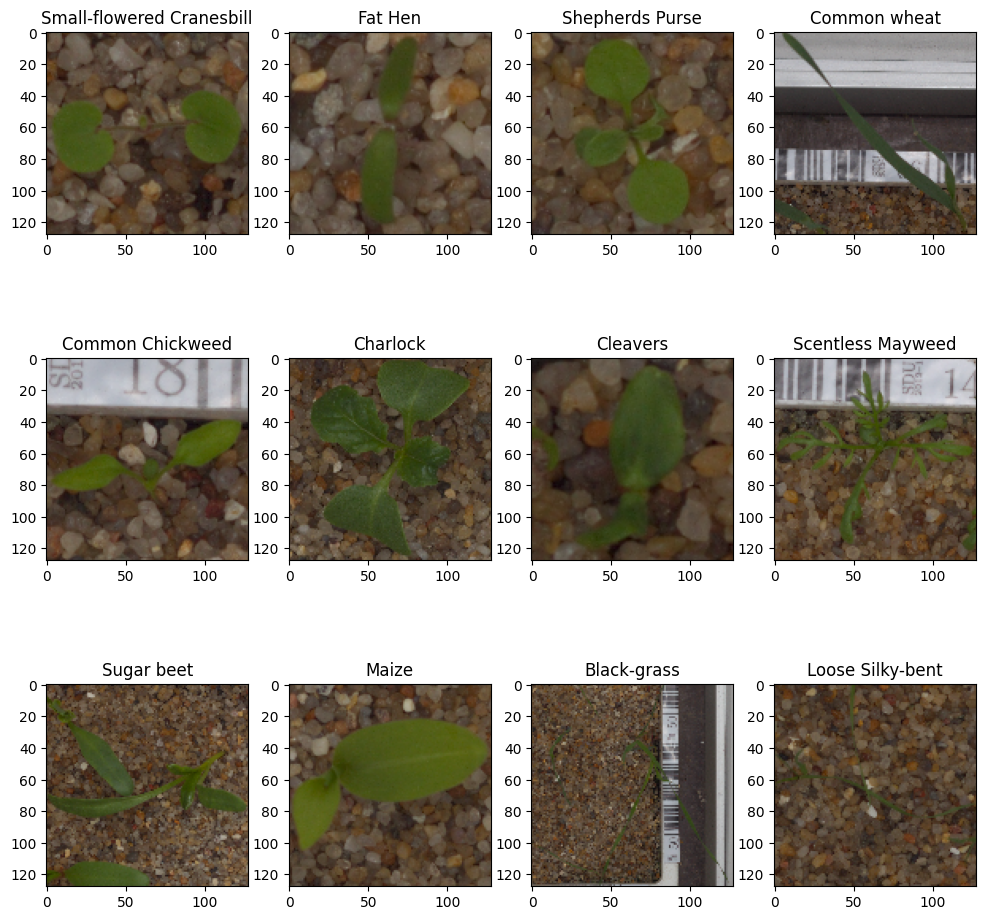

In [12]:
plot_images(images,labels)

**Observation**

1. The grid above displays the images post BGR to RGB conversion and now, we can see the background color corectly.

### Resize the images

Before Resizing


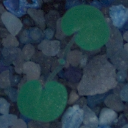

After Resizing


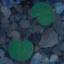

In [53]:
print('Before Resizing')
cv2_imshow(images[5])
print('After Resizing')

images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

cv2_imshow(images_decreased[5])

The size of the images is large (128*128), it will be computationally expensive to train on these larger images; therefore, the image size has been reduced   from 128 to 64 for reduced computations in the Neural Network.

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [14]:
X_Train,X_test, Y_train, Y_test = train_test_split(np.array(images_decreased), labels, test_size=0.1,random_state=1, stratify=labels)
X_Train,X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.1,random_state=1, stratify=Y_train)

In [15]:
print('Training Data set size', X_Train.shape)
print('Validation Data set size', X_val.shape)
print('Test Data set size', X_test.shape)

Training Data set size (3847, 64, 64, 3)
Validation Data set size (428, 64, 64, 3)
Test Data set size (475, 64, 64, 3)


**Observation**

The resized image data has been split into Training, Validation and test Data. Now we have 3847 images for training, 428 images for validation and 475 images for testing the data.

### Encode the target labels

In [16]:


from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()
Y_train_encoded = enc.fit_transform(Y_train)
Y_val_encoded=enc.transform(Y_val)
Y_test_encoded=enc.transform(Y_test)


### Data Normalization

In [17]:
# Normalizing the image pixels
X_train_normalized = X_Train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

**Observation**
1. Using LableBinarizer the labels have been converted into vectors. There are 12  unique labels in the Y, this method will generate one unique vecor for each label value in Y.
2. Each image pixel is represented between 0-255, this range (255) can impact the computations. So the data has to be normalized to reduce the range between 0 - 1.

## Model Building

In [18]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### **Models**

Created 2 different CNN models to classify the images provided in the dataset.

**Model 1** has 3 Convolution and 3 Pooling layers with padding size as 'Same' to get output size same as the input size followed by a fully connected dense layer with Softmax as activation in the output layer.

**Model 2** has 3 Convolution, 3 Pooling and 3 batch normalization layers with padding size as 'Same' to get output size same as the input sizefollowed by a fully connected dense layer with Softmax as activation in the output layer.

Using Categorical entrophy as loss factor as it involves more than 2 output categories. Since rightly identifying the image category is critical, precision/accuracy plays the main performance metrics, hence used 'Accuracy' as measuring metrics in the model.  

In [19]:
## MODEL 1 ##
def model_generation():

    model = Sequential()

    # Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' to get the output size same as the input size
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2), padding = 'same'))

    # Add another Convolution layer with 64 kernels of 3X3 shape with activation function ReLU
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D((2, 2), padding = 'same'))

    # Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D((2, 2), padding = 'same'))

    # flattening the output of the conv layer to be passed as input to next Neural Network for prediction
    model.add(Flatten())

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    # Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
    model.add(Dense(12, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model;

In [20]:
## MODEL 2 ##
def model1_generation():

    model1 = Sequential()

    # Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' to provid the output size same as the input size
    # Input_shape denotes input image dimension of images
    model1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2), padding = 'same'))

    # Add another Convolution layer with 64 kernels of 3X3 shape with activation function ReLU
    model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2), padding = 'same'))

    # Add another Convolution layer with 64 kernels of 3X3 shape with activation function ReLU
    model1.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D(pool_size = (2, 2),strides=2))

    # flattening the output of the conv layer to be passed as input to next Neural Network for prediction
    model1.add(Flatten())

    model1.add(Dense(32, activation='relu'))
    model1.add(Dropout(0.2))
    # Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
    model1.add(Dense(12, activation='softmax'))

    # Compile model
    model1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Generating the summary of the model
    #model.summary()

    return model1;

## **Fitting the model**

In [21]:
model_1 = model_generation()
model_1.summary()

history_1 = model_1.fit(
            X_train_normalized, Y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,Y_val_encoded),
            batch_size=32,
            verbose=2
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

## **Validation of the performance**

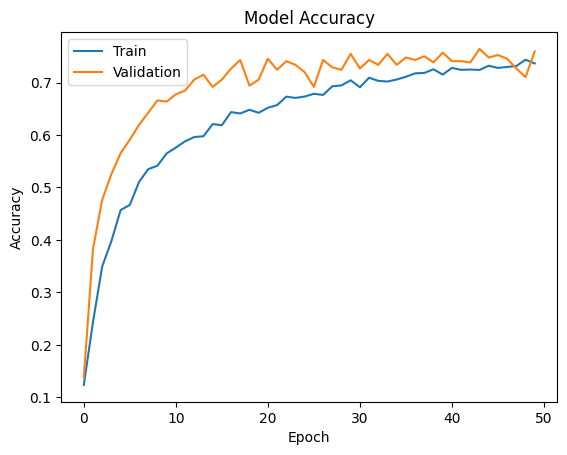

In [22]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**

1. The CNN Model-1 has shown a good learning path which is evident from the validation results. But the accuracy is the metric to watch out and the validation accuracy metric is always less than .80. Hence working on other accuracy improvement approaches.
2.  **Model_1 training accuracy: 0.7364 & validation accuracy: 0.7593**

## Model Performance Improvement

### **Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [23]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Using the ReduceLROnPlateau keras function to adjust the learning rate.

In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.02,
                              patience=5, min_lr=0.001)

In [25]:
model_2 = model_generation()
model_2.summary()
history_2 = model_2.fit(
            X_train_normalized, Y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,Y_val_encoded),
            batch_size=32,
            verbose=2,
            callbacks=[reduce_lr]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

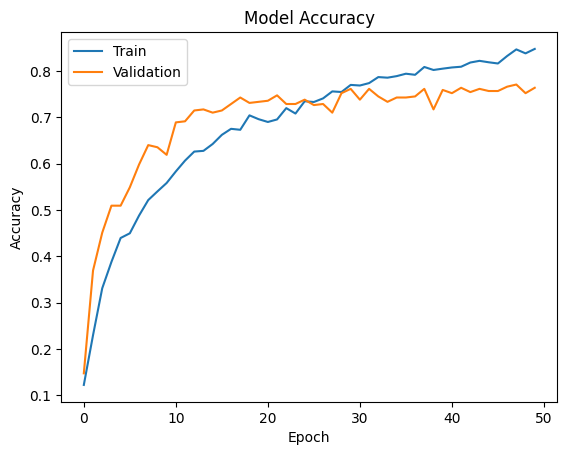

In [26]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**

1. Slight change in the prediction accuracy when the learning rate change factor is included.
2.  **Model_2's Training accuracy : 0.8479 & Validation accuracy: 0.7640**

### **Data Augmentation**

The  data provided was imbalanced, there are a few samples of certain seedling so we will use Data Image Augmentation technique to generate images for training purpose, this will help improve the accuracy.


Remember, **data augmentation should not be used in the validation/test data set**.

In [27]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [28]:
X_Train_datagen = ImageDataGenerator(
    rotation_range=30, fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True
)

In [29]:
model_3 = model_generation()
model_3.summary()
history_3 = model_3.fit_generator(X_Train_datagen.flow(X_train_normalized, Y_train_encoded,batch_size=32),
                    epochs=50,
                    steps_per_epoch=X_Train.shape[0]//32,
                    validation_data=(X_val_normalized,Y_val_encoded),
                    validation_steps=X_val_normalized.shape[0]//32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

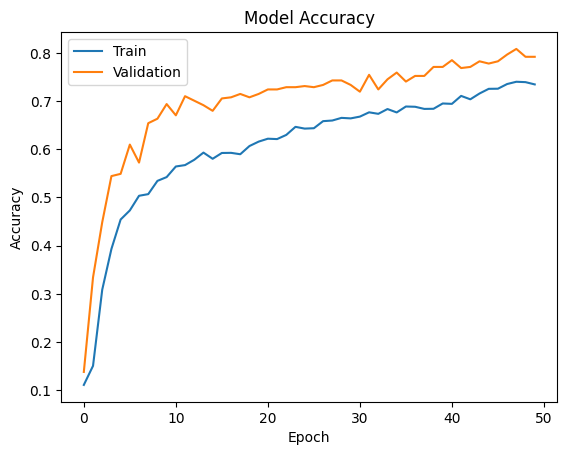

In [30]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


**Observations:**

1. ImageDataGenerator has been used to generate images with 30 degree rotation angle, flipped images (both horizontal and vertical) to create additional images to aid training purpose.
2. Training & Validation Accuracy of the model remained same as the previous models (model_1 and model_2)
3.  **Model_3 Training accuracy: 0.7347 & val_accuracy: 0.7921**


### **Fitting Model 2 and measuring Performance of Model 2**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                        

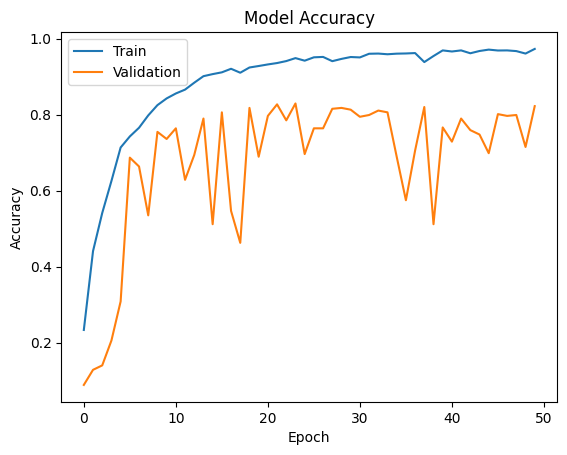

In [31]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

model_4 = model1_generation()
model_4.summary()

history_4 = model_4.fit(
            X_train_normalized, Y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,Y_val_encoded),
            batch_size=32,
            verbose=2
)

plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observation:**

1. This model with the batch normalization layer is helping the model learn better and accuracy metrics of trainng data is reflection of the same.
2. Though the validation accuracy metrics fluctuates a lot, the validation accuracy is .080
3. **Model_4 Training accuracy: 0.9730 & validation accuracy: 0.8224**


In [32]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [33]:
model_5 = model1_generation()
model_5.summary()
history_5 = model_5.fit(
            X_train_normalized, Y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,Y_val_encoded),
            batch_size=32,
            verbose=2,
            callbacks=[reduce_lr]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                        

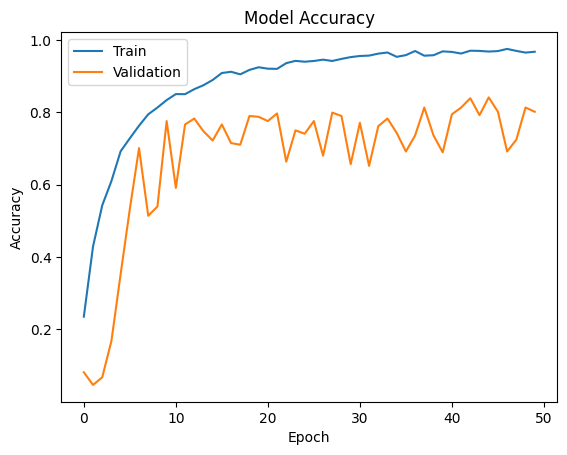

In [34]:
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observation:**

1. This model with the batch normalization layer is helping the model learn better and accuracy metrics of trainng data is reflection of the same.
2. Though the validation accuracy metrics fluctuates a lot, the validation accuracy is .078
3. **Model_5 Training accuracy: 0.9672 & validation accuracy: 0.8014**

In [35]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [36]:
model_6 = model1_generation()
model_6.summary()
history_6 = model_6.fit_generator(X_Train_datagen.flow(X_train_normalized, Y_train_encoded,batch_size=32),
                    epochs=50,callbacks=[reduce_lr],
                    steps_per_epoch=X_Train.shape[0]//32,
                    validation_data=(X_val_normalized,Y_val_encoded),
                    validation_steps=X_val_normalized.shape[0]//32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                        

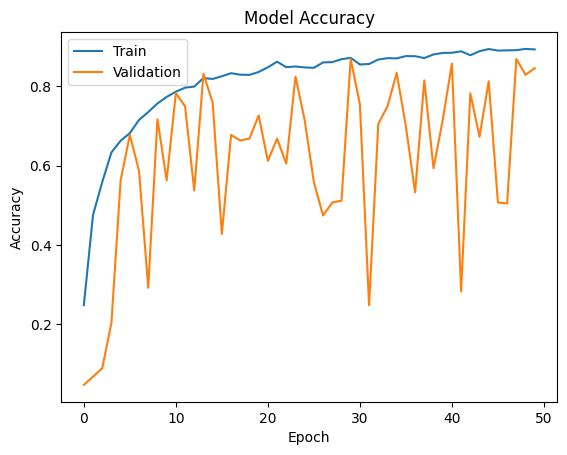

In [37]:
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


**Observations**
1. This model has given the highest validation accuracy out of all models.
2. Training and validation metrics are very close and has never exceeded the training validation at any point.  
3.  **Model_6's Training accuracy: 0.8933 & validation accuracy: 0.8458**

#### Accuracy Results

Basically, created two Convoluted Neural networks and tried to improvise the accuracy through different means. Below is the accuracy score of the models:

In [38]:
print ('Accuracy of Model1:', model_1.evaluate(X_test_normalized, Y_test_encoded, verbose=0)[1])
print ('Accuracy of Model2:', model_2.evaluate(X_test_normalized, Y_test_encoded, verbose=0)[1])
print ('Accuracy of Model3:', model_3.evaluate(X_test_normalized, Y_test_encoded, verbose=0)[1])
print ('Accuracy of Model4:', model_4.evaluate(X_test_normalized, Y_test_encoded, verbose=0)[1])
print ('Accuracy of Model5:', model_5.evaluate(X_test_normalized, Y_test_encoded, verbose=0)[1])
print ('Accuracy of Model6:', model_6.evaluate(X_test_normalized, Y_test_encoded, verbose=0)[1])

Accuracy of Model1: 0.7178947329521179
Accuracy of Model2: 0.7599999904632568
Accuracy of Model3: 0.7978947162628174
Accuracy of Model4: 0.8252631425857544
Accuracy of Model5: 0.8063157796859741
Accuracy of Model6: 0.8778947591781616


**Observations:**

1. Based on the accuracy scores, I see that the improved CNN Model6 showed the highest accuracy rate.

2. This model includes batch normalization layers and  learning rate adjustments factors. Also, this model was trained with images generated through the data augmentation processes.

3. Since accuracy score is important metric in this usecase, choosing the model_6 as the final model to visualize a few sample images.

###Performance Metrics of the models

In [40]:
from sklearn.metrics import classification_report

def prediction_results(model_parm):

  Y_pred = model_parm.predict(X_test_normalized)

  # Obtaining the categorical values from y_test_encoded and y_pred
  Y_pred_arg=np.argmax(Y_pred,axis=1)
  Y_test_arg=np.argmax(Y_test_encoded,axis=1)

  # Plotting the Confusion Matrix using confusion matrix() function
  confusion_matrix = tf.math.confusion_matrix(Y_test_arg,Y_pred_arg)
  f, ax = plt.subplots(figsize=(10, 8))
  sns.heatmap(
      confusion_matrix,
      annot=True,
      linewidths=.4,
      fmt="d",
      square=True,
      ax=ax
  )
  plt.xticks(rotation = 90)
  plt.yticks(rotation = 360)
  ax.set_xticklabels(enc.classes_)
  ax.set_yticklabels(enc.classes_)
  plt.show()

  print ('Performance Metrics: \n')
  print(classification_report(Y_pred_arg, Y_test_arg, target_names=enc.classes_))

15/15 [==============================] - 0s 4ms/step


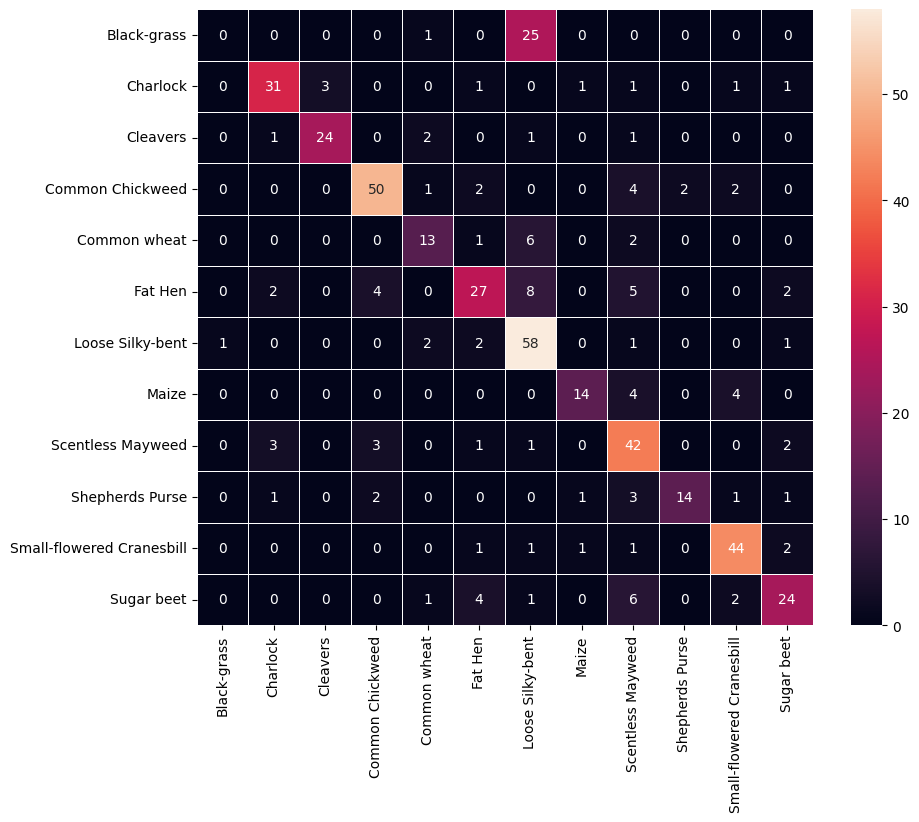

Performance Metrics: 

                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00         1
                 Charlock       0.79      0.82      0.81        38
                 Cleavers       0.83      0.89      0.86        27
         Common Chickweed       0.82      0.85      0.83        59
             Common wheat       0.59      0.65      0.62        20
                  Fat Hen       0.56      0.69      0.62        39
         Loose Silky-bent       0.89      0.57      0.70       101
                    Maize       0.64      0.82      0.72        17
        Scentless Mayweed       0.81      0.60      0.69        70
          Shepherds Purse       0.61      0.88      0.72        16
Small-flowered Cranesbill       0.88      0.81      0.85        54
               Sugar beet       0.63      0.73      0.68        33

                 accuracy                           0.72       475
                macro avg       0.67 

In [41]:
prediction_results(model_1)

**Observations:**
1. None of the Black-grass plant images were identified by the model. All of the Black-grass images were  identified as Loose Silky-bent by the model
2. Loose Silky-bent, Common Chickweed and Small-flowered Cranesbill seedlings were predicted well by this model.



15/15 [==============================] - 0s 3ms/step


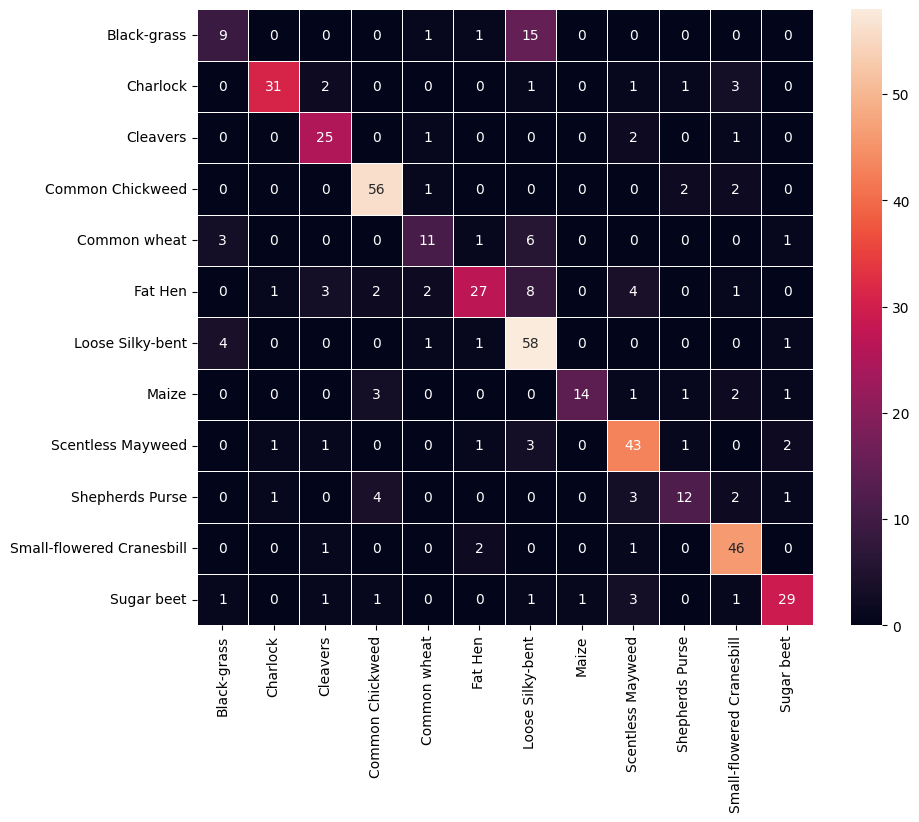

Performance Metrics: 

                           precision    recall  f1-score   support

              Black-grass       0.35      0.53      0.42        17
                 Charlock       0.79      0.91      0.85        34
                 Cleavers       0.86      0.76      0.81        33
         Common Chickweed       0.92      0.85      0.88        66
             Common wheat       0.50      0.65      0.56        17
                  Fat Hen       0.56      0.82      0.67        33
         Loose Silky-bent       0.89      0.63      0.74        92
                    Maize       0.64      0.93      0.76        15
        Scentless Mayweed       0.83      0.74      0.78        58
          Shepherds Purse       0.52      0.71      0.60        17
Small-flowered Cranesbill       0.92      0.79      0.85        58
               Sugar beet       0.76      0.83      0.79        35

                 accuracy                           0.76       475
                macro avg       0.71 

In [42]:
prediction_results(model_2)

**Observations:**
1. The model did  predict a few of the Black-grass seedlings accurately, the accuracy is 0.35. Most of the Black-grass was identified as Loose Silky-bent by the model
2. Common Chickweed & mall-flowered Cranesbill images were predicted well by this model, accuracy score is 0.92.
3. Overall accuracy is not good.

15/15 [==============================] - 0s 3ms/step


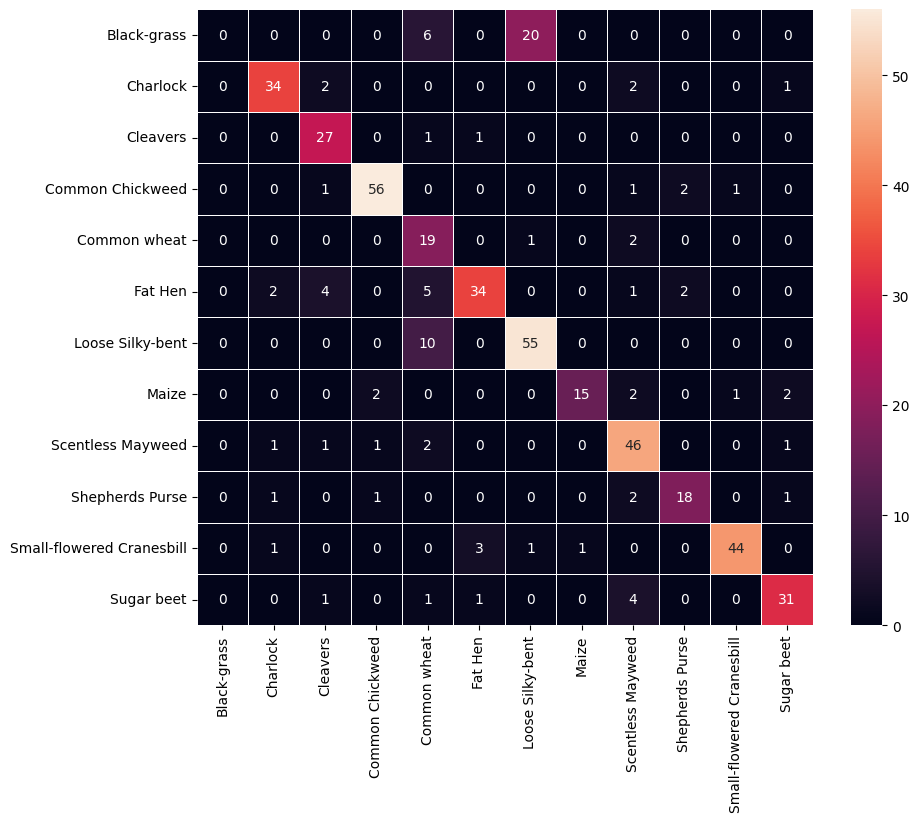

Performance Metrics: 

                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00         0
                 Charlock       0.87      0.87      0.87        39
                 Cleavers       0.93      0.75      0.83        36
         Common Chickweed       0.92      0.93      0.93        60
             Common wheat       0.86      0.43      0.58        44
                  Fat Hen       0.71      0.87      0.78        39
         Loose Silky-bent       0.85      0.71      0.77        77
                    Maize       0.68      0.94      0.79        16
        Scentless Mayweed       0.88      0.77      0.82        60
          Shepherds Purse       0.78      0.82      0.80        22
Small-flowered Cranesbill       0.88      0.96      0.92        46
               Sugar beet       0.82      0.86      0.84        36

                 accuracy                           0.80       475
                macro avg       0.77 

In [43]:
prediction_results(model_3)

**Observations:**
1. None of the Black-grass seedlings images in the test data were identified by the model, the accuracy is 0.0. All of the Black-grass images were identified as Loose Silky-bent by the model
2. Cleavers and Common Chickweed images from the test dataset were predicted well by this model.
3. Overall accuracy seems better compared to model 1 and 2, adding more blackgrass images along with zoomin and other data augmentation might help to improve accuracy.

15/15 [==============================] - 0s 3ms/step


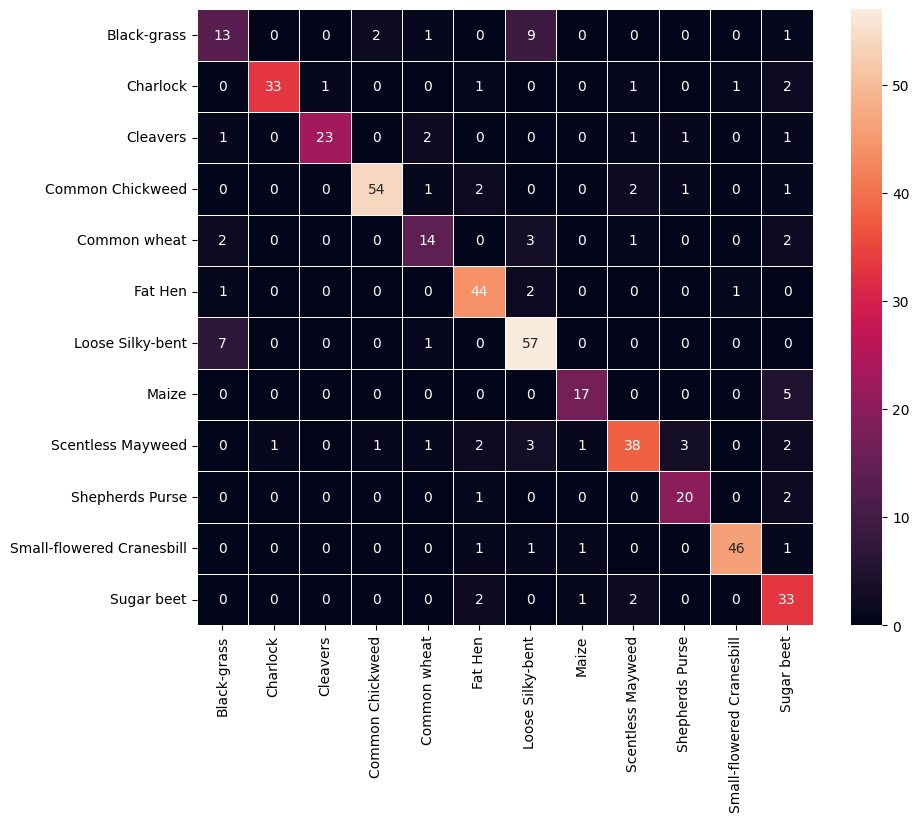

Performance Metrics: 

                           precision    recall  f1-score   support

              Black-grass       0.50      0.54      0.52        24
                 Charlock       0.85      0.97      0.90        34
                 Cleavers       0.79      0.96      0.87        24
         Common Chickweed       0.89      0.95      0.92        57
             Common wheat       0.64      0.70      0.67        20
                  Fat Hen       0.92      0.83      0.87        53
         Loose Silky-bent       0.88      0.76      0.81        75
                    Maize       0.77      0.85      0.81        20
        Scentless Mayweed       0.73      0.84      0.78        45
          Shepherds Purse       0.87      0.80      0.83        25
Small-flowered Cranesbill       0.92      0.96      0.94        48
               Sugar beet       0.87      0.66      0.75        50

                 accuracy                           0.83       475
                macro avg       0.80 

In [44]:
prediction_results(model_4)

**Observations:**
1. Few of the Black-grass seedlings images in the test data were identified by the model, the accuracy is 0.50. Most of the Black-grass was identified as Loose Silky-bent by the model. This is the best score so far with regards to black grass.
3. Fat Hen and Small-flowered Cranesbill seedling images from the test dataset were predicted well by this model.
4. Overall the model accuracy results looks good

15/15 [==============================] - 0s 3ms/step


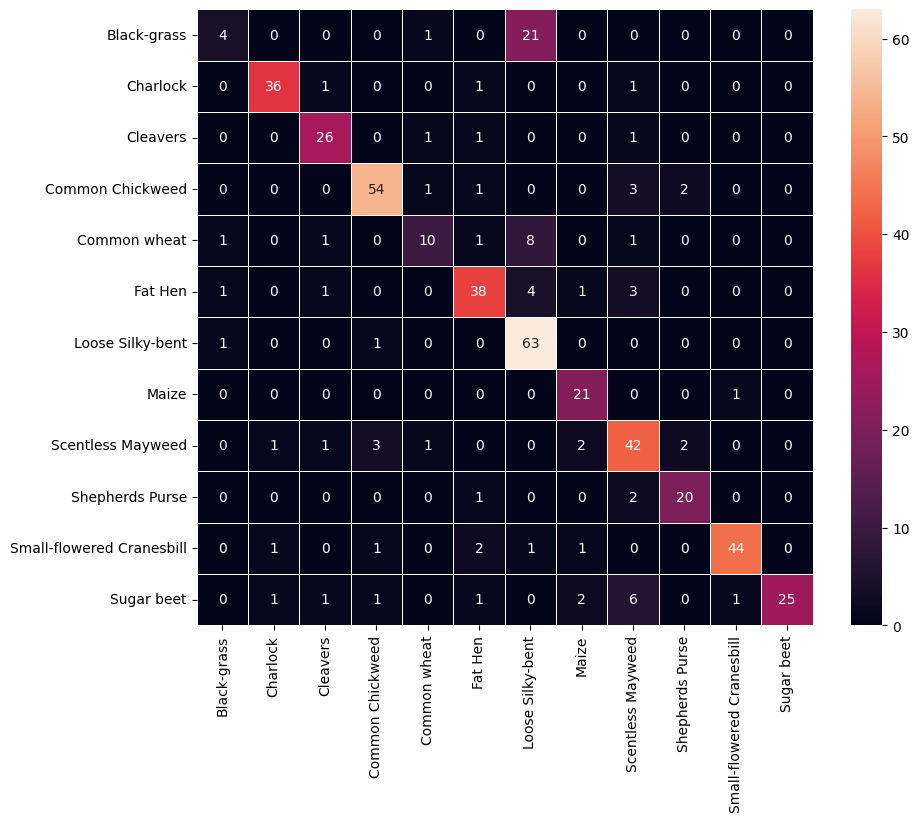

Performance Metrics: 

                           precision    recall  f1-score   support

              Black-grass       0.15      0.57      0.24         7
                 Charlock       0.92      0.92      0.92        39
                 Cleavers       0.90      0.84      0.87        31
         Common Chickweed       0.89      0.90      0.89        60
             Common wheat       0.45      0.71      0.56        14
                  Fat Hen       0.79      0.83      0.81        46
         Loose Silky-bent       0.97      0.65      0.78        97
                    Maize       0.95      0.78      0.86        27
        Scentless Mayweed       0.81      0.71      0.76        59
          Shepherds Purse       0.87      0.83      0.85        24
Small-flowered Cranesbill       0.88      0.96      0.92        46
               Sugar beet       0.66      1.00      0.79        25

                 accuracy                           0.81       475
                macro avg       0.77 

In [45]:
prediction_results(model_5)

**Observations:**
1. Dip in identifying the Black-grass seedlings images in the test data, the accuracy is 0.15. Most of the Black-grass was identified as Loose Silky-bent by the model.
2. Loose Silky-bent and Maize images from the test dataset were predicted well by this model.
3. Overall the model looks good

15/15 [==============================] - 0s 3ms/step


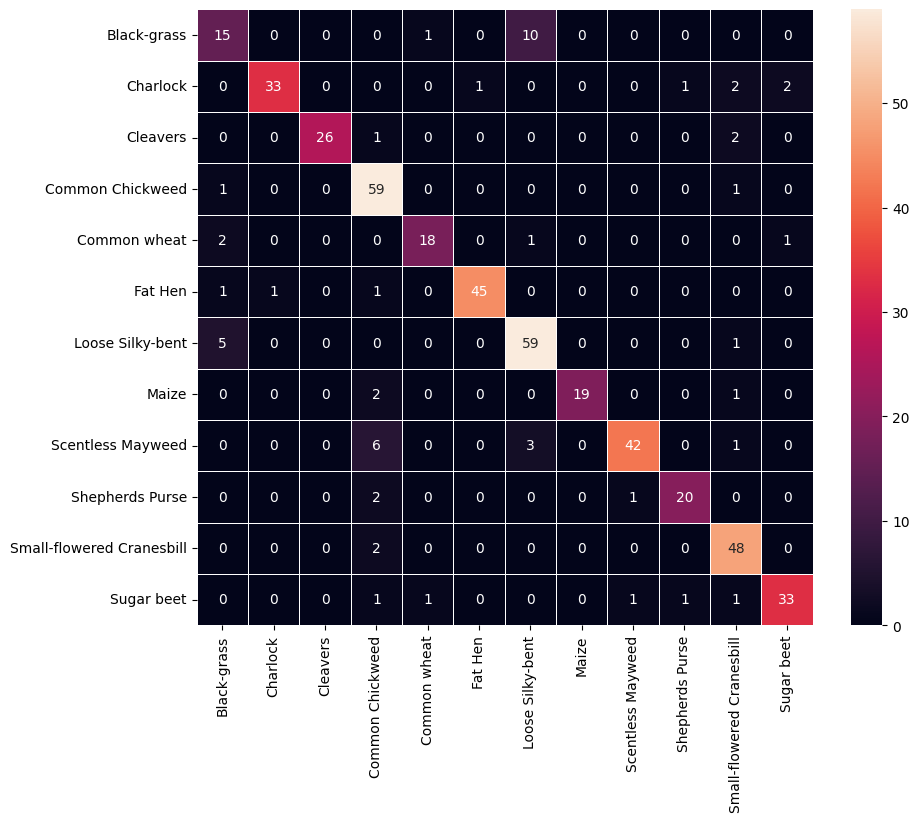

Performance Metrics: 

                           precision    recall  f1-score   support

              Black-grass       0.58      0.62      0.60        24
                 Charlock       0.85      0.97      0.90        34
                 Cleavers       0.90      1.00      0.95        26
         Common Chickweed       0.97      0.80      0.87        74
             Common wheat       0.82      0.90      0.86        20
                  Fat Hen       0.94      0.98      0.96        46
         Loose Silky-bent       0.91      0.81      0.86        73
                    Maize       0.86      1.00      0.93        19
        Scentless Mayweed       0.81      0.95      0.88        44
          Shepherds Purse       0.87      0.91      0.89        22
Small-flowered Cranesbill       0.96      0.84      0.90        57
               Sugar beet       0.87      0.92      0.89        36

                 accuracy                           0.88       475
                macro avg       0.86 

In [46]:
prediction_results(model_6)

**Observations:**
1. So far the best score for Black-grass seedlings images in the test data, the accuracy is 0.58. 15 images of blackgeass were identified correctly.
2. Common Chickweed and Small-flowered Cranesbill prediction scores wwere highest, model predicted these images accurately.
3. Overall the model looks good, prediction accuracy of all images were highest amongst the models.  

## Final Model

### **Conclusion:**

Based on the accuracy scores and the results of image classifications across all images, I have chosen the model_6 as the final model.

In the next section, I will be displaying the predicted category, actual category, the name of the category along with the image.  

### Visualizing the prediction

Below is the display of the predictions generated by the model, chose a few sample images from the test dataset (1,2,52 and 56) and predicted the seedling category using model_6.

1/1 [==============================] - 0s 65ms/step
Model predicted category for X_test 1 is:  [10] Actual Category 10
Category Name for X_test 1 is:  Small-flowered Cranesbill




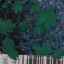



1/1 [==============================] - 0s 67ms/step
Model predicted category for X_test 2 is:  [5] Actual Category 5
Category Name for X_test 2 is:  Fat Hen




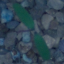



1/1 [==============================] - 0s 31ms/step
Model predicted category for X_test 52 is:  [7] Actual Category 7
Category Name for X_test 52 is:  Maize




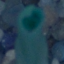



1/1 [==============================] - 0s 30ms/step
Model predicted category for X_test 56 is:  [3] Actual Category 3
Category Name for X_test 56 is:  Common Chickweed




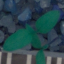

In [48]:
pred_1 = np.argmax(model_6.predict(np.expand_dims(X_test_normalized[1],axis=0)),axis=1)
actual_1 = np.argmax(Y_test_encoded[1])
print("Model predicted category for X_test 1 is: ", pred_1, 'Actual Category', actual_1)
print("Category Name for X_test 1 is: ",enc.classes_[actual_1] )
print("\n")
cv2_imshow(X_test[1])
print("\n")

pred_2 = np.argmax(model_6.predict(np.expand_dims(X_test_normalized[2],axis=0)),axis=1)
actual_2 = np.argmax(Y_test_encoded[2])
print("Model predicted category for X_test 2 is: ", pred_2, 'Actual Category', actual_2)
print("Category Name for X_test 2 is: ",enc.classes_[actual_2])
print("\n")
cv2_imshow(X_test[2])
print("\n")

pred_52 = np.argmax(model_6.predict(np.expand_dims(X_test_normalized[52],axis=0)),axis=1)
actual_52 = np.argmax(Y_test_encoded[52])
print("Model predicted category for X_test 52 is: ", pred_52, 'Actual Category', actual_52)
print("Category Name for X_test 52 is: ",enc.classes_[actual_52])
print("\n")
cv2_imshow(X_test[52])
print("\n")

pred_56 = np.argmax(model_6.predict(np.expand_dims(X_test_normalized[56],axis=0)),axis=1)
actual_56 = np.argmax(Y_test_encoded[56])
print("Model predicted category for X_test 56 is: ", pred_56, 'Actual Category', actual_56)
print("Category Name for X_test 56 is: ",enc.classes_[actual_56])
print("\n")
cv2_imshow(X_test[56])
print("\n")

## Actionable Insights and Business Recommendations

*   We have built a CNN-model to predict the category of the seedling and the model works quite well. Increasing number of epochs and/or including a few more image augmentation parameters to the model can even increase the performance.
*   Training the model with more Black-grass images (either real images or generated via image augmentation) can improve the accuracy of the model.
*   CNN with Batch Normalization, Maxpooling + Dense layers is a good combination for image classification







_____